In [59]:
import numpy as np
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import math

In [60]:
def nextpow2(N):
    n = 1
    while n < N: n *= 2
    return n

In [61]:
def F_getSpectreFromAudio(x, Nfft, sr_hz, plot=False):
    """
    inputs:
        - x: signal
        - L_n: window duration in samples
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftFreq_hz_v (N/2+1,): vector containing the DFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the DFT amplitudes
    """


    return fftFreq_hz_v, fftAmpl_v

In [62]:
def F_getF0FromSpectre(
    fftFreq_hz_v, fftAmpl_v, H, fmin_hz, fmax_hz, Nfft, sr_hz, plot=False
):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude
        - H: number of times the spectrum is decimated
        - fmin_hz: minimum frequency in Hz to look for F0
        - fmax_hz: maximum frequency in Hz to look for F0
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - spFreq_hz_v: vector containing the SpectralProduct frequencies in Hz
        - spAmpl_v: vector containing the SpectralProduct amplitudes
        - f0_hz: estimated F0 in Hz
    """
    R = int(Nfft / (2 * H) + 1)
    P = np.zeros(R)
    h = np.atleast_2d(np.arange(1, H + 1)).T
    f_k = np.arange(1, R + 1)
    A = np.abs(fftAmpl_v[h * f_k])
    P = np.prod(A, axis=0)
    F = np.linspace(0, sr_hz / (2 * H), R)

    spAmpl_v = P
    spFreq_hz_v = F

    n_min = int(fmin_hz / sr_hz * Nfft)
    n_max = int(fmax_hz / sr_hz * Nfft)
    assert n_max < R, "f_max est trop grand !"

    f0_hz = F[n_min:n_max][np.argmax(spAmpl_v[n_min:n_max])]

    return spFreq_hz_v, spAmpl_v, f0_hz

In [63]:
def F_getHarmonicsFromF0AndSpectre(
    fftFreq_hz_v, fftAmpl_v, f0_hz, Nfft, sr_hz, plot=False
):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude
        - f0_hz: estimated F0 in Hz
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - harmoFreq_k_v: vector containing the position/index of the Harmonics (position in fftFreq_hz_v or fftAmpl_v)
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
    """
    def get_max_harmo(h):
        alpha = 0.01
        beta = 0.0002
        f_inharmo = h * f0_hz * np.sqrt(1 + (h**2 - 1) * beta)
        print(f0_hz, h, f_inharmo)
        f_kmin = (1 - alpha) * f_inharmo
        f_kmax = (1 + alpha) * f_inharmo

        n_min = np.int64(f_kmin / sr_hz * Nfft)
        n_max = np.int64(f_kmax / sr_hz * Nfft)

        i_harmo = np.argmax(fftAmpl_v[n_min:n_max])
        a_harmo = fftAmpl_v[n_min:n_max][i_harmo]

        return i_harmo + n_min, a_harmo

    # f0_hz = fftFreq_hz_v[get_max_harmo(1)[0]]
    # print("ajusté à", f0_hz)
    nHarmos = 10  # TODO: calculer le bon nombre d'harmoniques

    harmoFreq_k_v = np.zeros(nHarmos, np.int64)
    harmoAmpl_v = np.zeros(nHarmos)
    for h in range(nHarmos):
        harmoFreq_k_v[h], harmoAmpl_v[h] = get_max_harmo(h + 1)

    return harmoFreq_k_v, harmoAmpl_v

In [64]:
# note <-> fréquence
def freq_to_midi(freq: float):
    note_number_f = 12 * math.log2(freq / 440) + 49
    note_number = round(note_number_f)
    delta = note_number_f - note_number
    return note_number, delta


def midi_to_name(midi: int):
    notes = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
    note = (midi - 1) % len(notes)
    note = notes[note]
    octave = (midi + 8) // len(notes)

    return note + str(octave)

le signal commence à 0.11245833333333333
Noise floor: -28.72 dB
le signal finit à 0.21247916666666666


/tmp/ipykernel_13459/494944591.py:38: RuntimeWarning: divide by zero encountered in log
  plt.plot(t, 20*np.log(abs(sig)))
/tmp/ipykernel_13459/494944591.py:39: RuntimeWarning: divide by zero encountered in log
  plt.plot(-t[:len(sig_start)], 20*np.log(abs(sig_start)))


ValueError: x and y must have same first dimension, but have shapes (4801,) and (5398,)

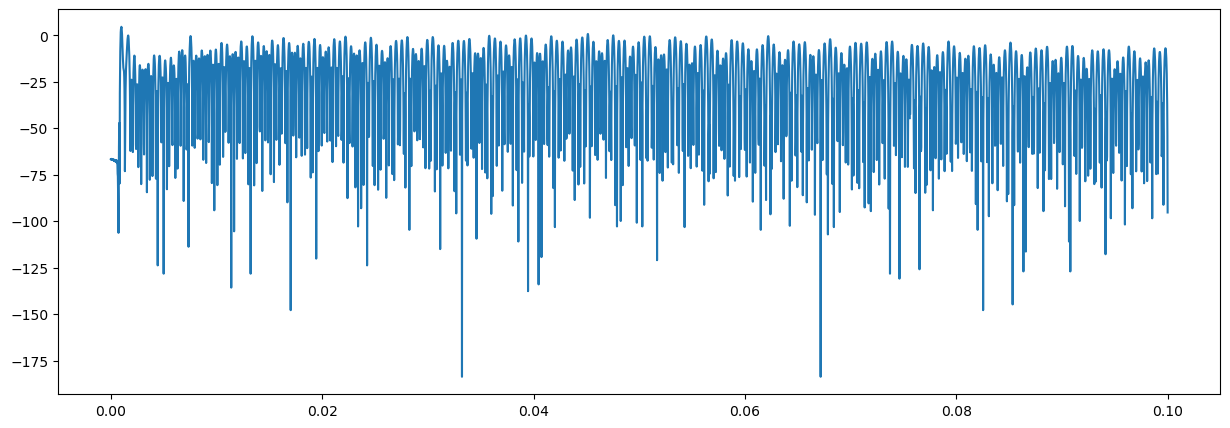

In [127]:
window = np.hamming

fs, sig = scipy.io.wavfile.read("vibra-fa2-1.wav")
sig = sig.astype(np.float32)
sig/=np.max(sig)

Nfft = 4 * nextpow2(len(sig))
freqs = np.fft.fftfreq(Nfft, 1 / fs)

# cut start
i_start = np.argmax(abs(sig)) - round(0.001*fs)
assert(i_start>100)
sig_start = sig[:i_start]
print("le signal commence à", i_start/fs)

# detect noise floor
# noise_floor_fft = np.fft.fft(sig_start * window(len(sig_start)), Nfft) / len(sig_start)
# sig_fft = np.fft.fft(sig * window(len(sig)), Nfft) / len(sig)
# sig_denoise_fft = np.where(sig_fft > noise_floor_fft, sig_fft, 0)
# # plt.plot(freqs, 20*np.log(sig_fft))
# plt.plot(freqs, 20*np.log(abs(sig_denoise_fft)))
# plt.show()
noise_floor = np.max(np.abs(sig_start))
print(f"Noise floor: {20*np.log10(noise_floor):.2f} dB")
# i_end = None
i_search =i_start+round(0.1*fs)
i_end=i_search + np.argmin(abs(sig[i_search:]) < noise_floor)
print("le signal finit à", i_end/fs)
sig_end=sig[i_end:]

# trim signal
sig = sig[i_start:i_end]


t = np.arange(len(sig)) / fs
# sig = sig/max(sig)
plt.figure(figsize=(15,5))
plt.plot(t, 20*np.log(abs(sig)))
plt.plot(-t[:len(sig_start)], 20*np.log(abs(sig_start)))
plt.hlines(20*np.log(abs(noise_floor)), -t[len(sig_start)], t[-1], 'red', 'dashed')
plt.show()

# hilbert = scipy.signal.hilbert(x_norm)
# envelope = abs(hilbert)
# plt.plot(envelope)

87.71 Hz, (=F2+0.08 Hz)
170097 peaks


(20, 20000)

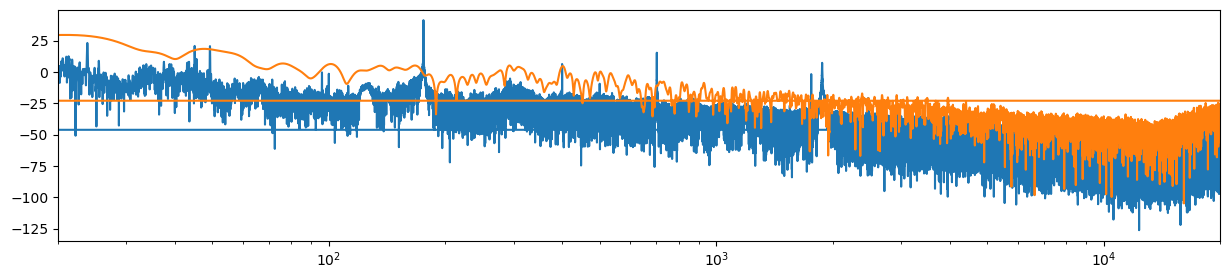

In [93]:
freqs, mag = F_getSpectreFromAudio(sig, Nfft, fs)
sp_freqs, sp_mag, f0 = F_getF0FromSpectre(freqs, mag, 2, 50, 300, Nfft, fs)
midi, delta = freq_to_midi(f0)
print(f"{f0:.2f} Hz, (={midi_to_name(midi)}{delta:+.2f} Hz)")
# harmo_freq, harmo_ampl = F_getHarmonicsFromF0AndSpectre(freqs, mag, f0, Nfft, fs)
harmo_freq, _ = scipy.signal.find_peaks(20*np.log10(mag), height=(-50, 0))
plt.figure(figsize=(15,3))
plt.semilogx(freqs, 20*np.log10(mag))
plt.semilogx(freqs, 20*np.log10(np.abs(noise_floor_fft)))
print(len(harmo_freq), "peaks")
if len(harmo_freq) < 50:
    plt.semilogx(freqs[harmo_freq], 20*np.log10(mag[harmo_freq]), 'x')
    for x,y in zip(freqs[harmo_freq], 20*np.log10(mag[harmo_freq])):
        plt.annotate(f"{x:.1f} Hz", (x, y))
plt.xlim(20,20000)

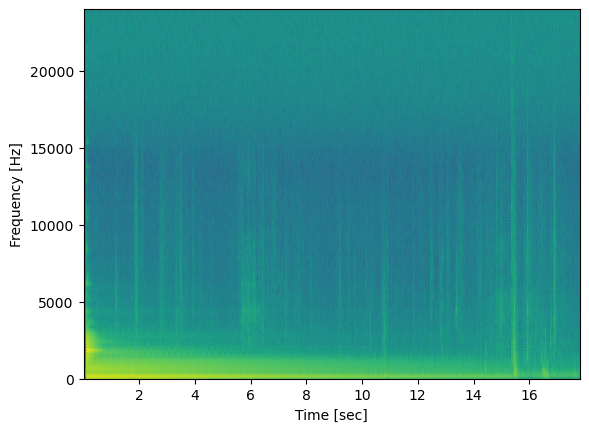

In [4]:
f, t, Sxx = scipy.signal.spectrogram(sig, fs)

plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()